In [ ]:
# Libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import random
import sklearn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Remove printing error
pd.options.mode.chained_assignment = None

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score


from functions_folder.nn_MIMICDataset import MIMICDataset
from functions_folder.nn_train import train
from functions_folder.nn_evaluate import evaluate
from functions_folder.nn_model_simplex import *
from functions_folder.genetic import *
from functions_folder.short import *

In [2]:
# Set the random seeds for deterministic results.
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
eicu_data = pd.read_csv('eicu_data.csv')
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
eicu_data2 = eicu_data[shap_list]

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

'''stays = eicu_data2['stay_id'].unique()
X_data = eicu_data2.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
eicu_data3 = pd.concat([eicu_data2[['stay_id', 'po_flag']], X_data], axis=1)'''

stays = eicu_data2['stay_id'].unique()
import random
random.Random(26).shuffle(stays) # Best eicu split from CV

X_data = eicu_data2.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([eicu_data2[['stay_id', 'po_flag']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]

"stays = eicu_data2['stay_id'].unique()\nX_data = eicu_data2.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])\n# Filter for features in this individual\nX_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]\neicu_data3 = pd.concat([eicu_data2[['stay_id', 'po_flag']], X_data], axis=1)"

In [4]:
# Dataloader
batch_size = len(test_data)
#batch_size = 32
test_dataset = MIMICDataset(test_data)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=test_dataset.collate_fn_padd)

In [5]:
# Get model
string = 'short'

# Define loss
criterion = nn.BCEWithLogitsLoss()

# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

model.load_state_dict(torch.load(f'eicu_switch_model_{string}.pt'))

<All keys matched successfully>

In [6]:
# Get predictions
test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, test_dataloader, criterion)

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


In [7]:
# Use new cut off
lower_bound_test_predictions, upper_bound_test_predictions = new_threshold_fun(test_predictions)

In [8]:
# Lower bound
test_auroc2 = roc_auc_score(test_labels, lower_bound_test_predictions)
print('Test AUROC result 2:', test_auroc2)
test_accuracy2 = accuracy_score(test_labels, lower_bound_test_predictions)
#assert test_accuracy == test_accuracy2
test_balanced_accuracy = balanced_accuracy_score(test_labels, lower_bound_test_predictions)
test_recall = recall_score(test_labels, lower_bound_test_predictions)
test_precision = precision_score(test_labels, lower_bound_test_predictions)
test_f1 = f1_score(test_labels, lower_bound_test_predictions)
test_auprc = average_precision_score(test_labels, lower_bound_test_predictions)
test_cm = confusion_matrix(test_labels, lower_bound_test_predictions)
tn, fp, fn, tp = test_cm.ravel()
test_true_positive_rate = (tp / (tp + fn))
test_false_positive_rate = (fp / (fp + tn))

# Upper bound
ub_test_auroc2 = roc_auc_score(test_labels, upper_bound_test_predictions)
ub_test_accuracy2 = accuracy_score(test_labels, upper_bound_test_predictions)
ub_test_balanced_accuracy = balanced_accuracy_score(test_labels, upper_bound_test_predictions)
ub_test_recall = recall_score(test_labels, upper_bound_test_predictions)
ub_test_precision = precision_score(test_labels, upper_bound_test_predictions)
ub_test_f1 = f1_score(test_labels, upper_bound_test_predictions)
ub_test_auprc = average_precision_score(test_labels, upper_bound_test_predictions)
ub_test_cm = confusion_matrix(test_labels, upper_bound_test_predictions)
tn, fp, fn, tp = ub_test_cm.ravel()
ub_test_true_positive_rate = (tp / (tp + fn))
ub_test_false_positive_rate = (fp / (fp + tn))

test_auroc_results = []
test_accuracy_results = []
test_balanced_accuracy_results = []
test_recall_results = []
test_precision_results = []
test_f1_results = []
test_auprc_results = []
test_cm_results = []
test_true_positive_rate_results = []
test_fasle_positive_rate_results = []

ub_test_auroc_results = []
ub_test_accuracy_results = []
ub_test_balanced_accuracy_results = []
ub_test_recall_results = []
ub_test_precision_results = []
ub_test_f1_results = []
ub_test_auprc_results = []
ub_test_cm_results = []
ub_test_true_positive_rate_results = []
ub_test_fasle_positive_rate_results = []

test_auroc_results.append(test_auroc2)
test_accuracy_results.append(test_accuracy2)
test_balanced_accuracy_results.append(test_balanced_accuracy)
test_recall_results.append(test_recall)
test_precision_results.append(test_precision)
test_f1_results.append(test_f1)
test_auprc_results.append(test_auprc)
test_cm_results.append(test_cm)
test_true_positive_rate_results.append(test_true_positive_rate)
test_fasle_positive_rate_results.append(test_false_positive_rate)

ub_test_auroc_results.append(ub_test_auroc2)
ub_test_accuracy_results.append(ub_test_accuracy2)
ub_test_balanced_accuracy_results.append(ub_test_balanced_accuracy)
ub_test_recall_results.append(ub_test_recall)
ub_test_precision_results.append(ub_test_precision)
ub_test_f1_results.append(ub_test_f1)
ub_test_auprc_results.append(ub_test_auprc)
ub_test_cm_results.append(ub_test_cm)
ub_test_true_positive_rate_results.append(ub_test_true_positive_rate)
ub_test_fasle_positive_rate_results.append(ub_test_false_positive_rate)

test_results = [test_auroc_results, test_accuracy_results,
test_balanced_accuracy_results,
test_recall_results,
test_precision_results,
test_f1_results,
test_auprc_results,
test_cm_results,
test_true_positive_rate_results,
test_fasle_positive_rate_results
]

ub_test_results = [ub_test_auroc_results, ub_test_accuracy_results,
ub_test_balanced_accuracy_results,
ub_test_recall_results,
ub_test_precision_results,
ub_test_f1_results,
ub_test_auprc_results,
ub_test_cm_results,
ub_test_true_positive_rate_results,
ub_test_fasle_positive_rate_results
]

analyze_results_fun(test_results)
analyze_results_fun(ub_test_results)

Test AUROC result 2: 0.7620900321543409
mean test_auroc: 0.7620900321543409
std test_auroc: 0.0
test_auroc 2.5th percentile: 0.7620900321543409
test_auroc 97.5th percentile: 0.7620900321543409
mean test_accuracy: 0.7266839378238342
std test_accuracy: 0.0
test_accuracy 2.5th percentile: 0.7266839378238342
test_accuracy 97.5th percentile: 0.7266839378238342
mean test_balanced_accuracy: 0.7620900321543408
std test_balanced_accuracy: 0.0
test_balanced_accuracy 2.5th percentile: 0.7620900321543408
test_balanced_accuracy 97.5th percentile: 0.7620900321543408
mean test_recall: 0.82
std test_recall: 0.0
test_recall 2.5th percentile: 0.82
test_recall 97.5th percentile: 0.82
mean test_precision: 0.4006514657980456
std test_precision: 0.0
test_precision 2.5th percentile: 0.4006514657980456
test_precision 97.5th percentile: 0.4006514657980456
mean test_f1: 0.5382932166301969
std test_f1: 0.0
test_f1 2.5th percentile: 0.5382932166301969
test_f1 97.5th percentile: 0.5382932166301969
mean test_auprc:

In [9]:
# Add to df
test_data['lower_bound_test_predictions'] = lower_bound_test_predictions
test_data['upper_bound_test_predictions'] = upper_bound_test_predictions

In [10]:
test_data.po_flag.value_counts()
test_data.lower_bound_test_predictions.value_counts()
test_data.upper_bound_test_predictions.value_counts()

0    622
1    150
Name: po_flag, dtype: int64

0    465
1    307
Name: lower_bound_test_predictions, dtype: int64

0    701
1     71
Name: upper_bound_test_predictions, dtype: int64

In [12]:
test_data

,stay_id,po_flag,blood pressure systolic17_current_stay,heart rate17,blood pressure mean11_current_stay,o2 saturation pulseoxymetry3_current_stay,gcs - motor response15_current_stay,lower_bound_test_predictions,upper_bound_test_predictions
4175,175078,0,0.783755,0.884146,2.135618e-16,-1.000000,-1.0,0,0
4176,175078,0,0.384649,0.312846,1.803487e-01,0.391705,-1.0,0,0
4177,175078,0,0.299317,0.368594,2.918510e-01,0.289116,-1.0,0,0
4178,175078,0,0.212758,0.164882,1.400659e-01,0.236065,-1.0,1,0
4179,3243083,0,0.533731,0.572165,6.567154e-01,0.600907,-1.0,0,0
...,...,...,...,...,...,...,...,...,...
4942,3162570,0,0.354445,0.596654,3.097349e-01,0.310869,-1.0,0,0
4943,3162570,0,0.251976,0.572599,6.999925e-01,0.236065,-1.0,1,0
4944,3162570,0,0.249743,0.184394,7.222601e-01,0.200718,-1.0,1,0
4945,3162570,0,0.131436,0.265553,6.815674e-01,0.180124,-1.0,1,0


In [11]:
# get list 
eicu_data_list = model_data2.stay_id.unique().tolist()

In [12]:
# Import
patient = pd.read_csv(r"eicu-collaborative-research-database-2.0/patient.csv")
patient.rename(columns={'patientunitstayid': 'stay_id'}, inplace=True)
patient = patient[patient['stay_id'].isin(eicu_data_list)]

In [72]:
patient.hospitalid.value_counts()
patient.hospitalid.nunique()

420    240
73     150
243    123
252    113
248    104
      ... 
258      1
95       1
167      1
180      1
267      1
Name: hospitalid, Length: 61, dtype: int64

61

In [13]:
# Merge
test_data2 = test_data.merge(patient[['stay_id', 'hospitalid']])

In [74]:
test_data2

,stay_id,po_flag,blood pressure systolic17_current_stay,heart rate17,blood pressure mean11_current_stay,o2 saturation pulseoxymetry3_current_stay,gcs - motor response15_current_stay,lower_bound_test_predictions,upper_bound_test_predictions,hospitalid
0,175078,0,0.783755,0.884146,2.135618e-16,-1.000000,-1.0,0,0,63
1,175078,0,0.384649,0.312846,1.803487e-01,0.391705,-1.0,0,0,63
2,175078,0,0.299317,0.368594,2.918510e-01,0.289116,-1.0,0,0,63
3,175078,0,0.212758,0.164882,1.400659e-01,0.236065,-1.0,1,0,63
4,3243083,0,0.533731,0.572165,6.567154e-01,0.600907,-1.0,0,0,449
...,...,...,...,...,...,...,...,...,...,...
767,3162570,0,0.354445,0.596654,3.097349e-01,0.310869,-1.0,0,0,443
768,3162570,0,0.251976,0.572599,6.999925e-01,0.236065,-1.0,1,0,443
769,3162570,0,0.249743,0.184394,7.222601e-01,0.200718,-1.0,1,0,443
770,3162570,0,0.131436,0.265553,6.815674e-01,0.180124,-1.0,1,0,443


In [14]:
# Filter for those with switch and not
hospital_list = test_data2.groupby(['hospitalid'])['po_flag'].nunique()[test_data2.groupby(['hospitalid'])['po_flag'].nunique() > 1].index.tolist()
test_data3 = test_data2[test_data2['hospitalid'].isin(hospital_list)]

In [45]:
test_data3.hospitalid.value_counts()
test_data3.hospitalid.nunique()

420    139
73      94
252     70
243     51
443     43
281     36
244     34
183     19
197     18
424     18
195     15
264     15
282     14
227     12
422     11
249     10
66       9
259      9
79       8
271      8
253      7
279      6
182      3
93       2
Name: hospitalid, dtype: int64

24

In [15]:
def hosp_group_fun(df):
    
    print(df.hospitalid.unique())

    # Define labels
    test_labels = df.po_flag

    # Define new predictions
    lower_bound_test_predictions = df.lower_bound_test_predictions
    upper_bound_test_predictions = df.upper_bound_test_predictions
    
    # Lower bound
    try:
        test_auroc2 = roc_auc_score(test_labels, lower_bound_test_predictions)
    except:
        test_auroc2 = np.nan
    print('Test AUROC result:', test_auroc2)
    test_accuracy2 = accuracy_score(test_labels, lower_bound_test_predictions)
    #assert test_accuracy == test_accuracy2
    test_balanced_accuracy = balanced_accuracy_score(test_labels, lower_bound_test_predictions)
    test_recall = recall_score(test_labels, lower_bound_test_predictions)
    test_precision = precision_score(test_labels, lower_bound_test_predictions)
    test_f1 = f1_score(test_labels, lower_bound_test_predictions)
    test_auprc = average_precision_score(test_labels, lower_bound_test_predictions)
    test_cm = confusion_matrix(test_labels, lower_bound_test_predictions)
    try:
        tn, fp, fn, tp = test_cm.ravel()
        test_true_positive_rate = (tp / (tp + fn))
        test_false_positive_rate = (fp / (fp + tn))
    except:
        test_true_positive_rate = np.nan
        test_false_positive_rate = np.nan

    # Upper bound
    try:
        ub_test_auroc2 = roc_auc_score(test_labels, upper_bound_test_predictions)
    except:
        ub_test_auroc2 = np.nan
    ub_test_accuracy2 = accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_balanced_accuracy = balanced_accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_recall = recall_score(test_labels, upper_bound_test_predictions)
    ub_test_precision = precision_score(test_labels, upper_bound_test_predictions)
    ub_test_f1 = f1_score(test_labels, upper_bound_test_predictions)
    ub_test_auprc = average_precision_score(test_labels, upper_bound_test_predictions)
    ub_test_cm = confusion_matrix(test_labels, upper_bound_test_predictions)
    try:
        tn, fp, fn, tp = ub_test_cm.ravel()
        ub_test_true_positive_rate = (tp / (tp + fn))
        ub_test_false_positive_rate = (fp / (fp + tn))
    except:
        ub_test_true_positive_rate = np.nan
        ub_test_false_positive_rate = np.nan

    test_auroc_results = []
    test_accuracy_results = []
    test_balanced_accuracy_results = []
    test_recall_results = []
    test_precision_results = []
    test_f1_results = []
    test_auprc_results = []
    test_cm_results = []
    test_true_positive_rate_results = []
    test_fasle_positive_rate_results = []

    ub_test_auroc_results = []
    ub_test_accuracy_results = []
    ub_test_balanced_accuracy_results = []
    ub_test_recall_results = []
    ub_test_precision_results = []
    ub_test_f1_results = []
    ub_test_auprc_results = []
    ub_test_cm_results = []
    ub_test_true_positive_rate_results = []
    ub_test_fasle_positive_rate_results = []

    test_auroc_results.append(test_auroc2)
    test_accuracy_results.append(test_accuracy2)
    test_balanced_accuracy_results.append(test_balanced_accuracy)
    test_recall_results.append(test_recall)
    test_precision_results.append(test_precision)
    test_f1_results.append(test_f1)
    test_auprc_results.append(test_auprc)
    test_cm_results.append(test_cm)
    test_true_positive_rate_results.append(test_true_positive_rate)
    test_fasle_positive_rate_results.append(test_false_positive_rate)

    ub_test_auroc_results.append(ub_test_auroc2)
    ub_test_accuracy_results.append(ub_test_accuracy2)
    ub_test_balanced_accuracy_results.append(ub_test_balanced_accuracy)
    ub_test_recall_results.append(ub_test_recall)
    ub_test_precision_results.append(ub_test_precision)
    ub_test_f1_results.append(ub_test_f1)
    ub_test_auprc_results.append(ub_test_auprc)
    ub_test_cm_results.append(ub_test_cm)
    ub_test_true_positive_rate_results.append(ub_test_true_positive_rate)
    ub_test_fasle_positive_rate_results.append(ub_test_false_positive_rate)

    test_results = [test_auroc_results, test_accuracy_results,
    test_balanced_accuracy_results,
    test_recall_results,
    test_precision_results,
    test_f1_results,
    test_auprc_results,
    test_cm_results,
    test_true_positive_rate_results,
    test_fasle_positive_rate_results
    ]

    ub_test_results = [ub_test_auroc_results, ub_test_accuracy_results,
    ub_test_balanced_accuracy_results,
    ub_test_recall_results,
    ub_test_precision_results,
    ub_test_f1_results,
    ub_test_auprc_results,
    ub_test_cm_results,
    ub_test_true_positive_rate_results,
    ub_test_fasle_positive_rate_results
    ]

    analyze_results_fun(test_results)
    analyze_results_fun(ub_test_results)

In [46]:
test_data3.groupby('hospitalid').apply(hosp_group_fun)

[66]
Test AUROC result: 0.5
mean test_auroc: 0.5
std test_auroc: 0.0
test_auroc 2.5th percentile: 0.5
test_auroc 97.5th percentile: 0.5
mean test_accuracy: 0.8888888888888888
std test_accuracy: 0.0
test_accuracy 2.5th percentile: 0.8888888888888888
test_accuracy 97.5th percentile: 0.8888888888888888
mean test_balanced_accuracy: 0.5
std test_balanced_accuracy: 0.0
test_balanced_accuracy 2.5th percentile: 0.5
test_balanced_accuracy 97.5th percentile: 0.5
mean test_recall: 0.0
std test_recall: 0.0
test_recall 2.5th percentile: 0
test_recall 97.5th percentile: 0.0
mean test_precision: 0.0
std test_precision: 0.0
test_precision 2.5th percentile: 0
test_precision 97.5th percentile: 0.0
mean test_f1: 0.0
std test_f1: 0.0
test_f1 2.5th percentile: 0
test_f1 97.5th percentile: 0.0
mean test_auprc: 0.1111111111111111
std test_auprc: 0.0
test_auprc 2.5th percentile: 0.1111111111111111
test_auprc 97.5th percentile: 0.1111111111111111
mean test_tpr: 0.0
std test_tpr: 0.0
test_tpr 2.5th percentile: 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


mean test_auroc: 0.785
std test_auroc: 0.0
test_auroc 2.5th percentile: 0.785
test_auroc 97.5th percentile: 0.785
mean test_accuracy: 0.7142857142857143
std test_accuracy: 0.0
test_accuracy 2.5th percentile: 0.7142857142857143
test_accuracy 97.5th percentile: 0.7142857142857143
mean test_balanced_accuracy: 0.7849999999999999
std test_balanced_accuracy: 0.0
test_balanced_accuracy 2.5th percentile: 0.7849999999999999
test_balanced_accuracy 97.5th percentile: 0.7849999999999999
mean test_recall: 0.95
std test_recall: 0.0
test_recall 2.5th percentile: 0.95
test_recall 97.5th percentile: 0.95
mean test_precision: 0.5
std test_precision: 0.0
test_precision 2.5th percentile: 0.5
test_precision 97.5th percentile: 0.5
mean test_f1: 0.6551724137931034
std test_f1: 0.0
test_f1 2.5th percentile: 0.6551724137931034
test_f1 97.5th percentile: 0.6551724137931034
mean test_auprc: 0.48928571428571427
std test_auprc: 0.0
test_auprc 2.5th percentile: 0.48928571428571427
test_auprc 97.5th percentile: 0.48

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


""


In [16]:
def hosp_group_fun2(df):
    
    #print(df.hospitalid.unique())

    # Define labels
    test_labels = df.po_flag

    # Define new predictions
    lower_bound_test_predictions = df.lower_bound_test_predictions
    upper_bound_test_predictions = df.upper_bound_test_predictions
    
    # Lower bound
    try:
        test_auroc = roc_auc_score(test_labels, lower_bound_test_predictions)
    except:
        test_auroc = np.nan

    '''# Upper bound
    try:
        ub_test_auroc = roc_auc_score(test_labels, upper_bound_test_predictions)
    except:
        ub_test_auroc = np.nan'''

    return test_auroc

def hosp_group_fun3(df):
    
    #print(df.hospitalid.unique())

    # Define labels
    test_labels = df.po_flag

    # Define new predictions
    lower_bound_test_predictions = df.lower_bound_test_predictions
    upper_bound_test_predictions = df.upper_bound_test_predictions
    
    '''# Lower bound
    try:
        test_auroc = roc_auc_score(test_labels, lower_bound_test_predictions)
    except:
        test_auroc = np.nan'''

    # Upper bound
    try:
        ub_test_auroc = roc_auc_score(test_labels, upper_bound_test_predictions)
    except:
        ub_test_auroc = np.nan

    return ub_test_auroc

In [17]:
# Get results 
test_data4 = test_data3.groupby('hospitalid').apply(hosp_group_fun2)
test_data5 = test_data3.groupby('hospitalid').apply(hosp_group_fun3)
# Create dfs
test_data4 = pd.DataFrame(test_data4)
test_data4.reset_index(inplace=True)
test_data4.columns = ['hospitalid', 'test_auroc']
test_data5 = pd.DataFrame(test_data5)
test_data5.reset_index(inplace=True)
test_data5.columns = ['hospitalid', 'ub_test_auroc']
value_count_df = pd.DataFrame(test_data3.hospitalid.value_counts())
value_count_df.reset_index(inplace=True)
value_count_df.columns = ['hospitalid', 'test_count']
temp_df = pd.merge(model_data2, patient[['stay_id', 'hospitalid']])
value_count_df2 = pd.DataFrame(temp_df.hospitalid.value_counts())
value_count_df2.reset_index(inplace=True)
value_count_df2.columns = ['hospitalid', 'full_count']
# Merge
hospital_df = pd.merge(test_data4, test_data5)
hospital_df = pd.merge(hospital_df, value_count_df)
hospital_df = pd.merge(hospital_df, value_count_df2)
#hospital_df.sort_values(by=['full_count', 'test_count'], ascending=False, inplace=True)
hospital_df.sort_values(by=['hospitalid'], ascending=True, inplace=True)
hospital_df.reset_index(inplace=True, drop=True)

In [116]:
hospital_df

,hospitalid,test_auroc,ub_test_auroc,test_count,full_count
0,66,0.500000,0.500000,9,76
1,73,0.814394,0.494318,94,424
2,79,1.000000,0.500000,8,87
3,93,0.500000,0.500000,2,2
4,182,0.500000,1.000000,3,10
5,183,0.833333,0.739583,19,64
6,195,0.562500,0.508929,15,17
7,197,0.750000,0.900000,18,19
8,227,0.555556,0.500000,12,62
9,243,0.757937,0.666667,51,340


In [19]:
hospital_df.test_auroc.max()
hospital_df.test_auroc.min()

1.0

0.2777777777777778

<BarContainer object of 24 artists>

Text(0, 0.5, 'AUROC')

Text(0.5, 1.0, 'Test AUROC for different hospitals in eICU')

Text(0.5, 0, 'Hospital_id number')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

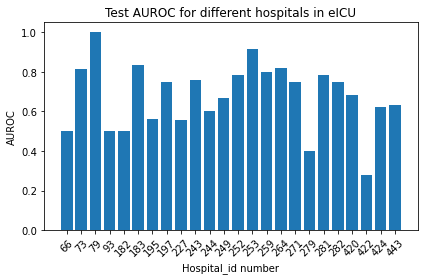

In [18]:
# Add some text for labels, title and custom x-axis tick labels, etc.
#plt.figure(figsize = (15,8))
plt.bar(hospital_df.hospitalid.astype(str), hospital_df.test_auroc)
plt.ylabel('AUROC')
plt.title('Test AUROC for different hospitals in eICU')
plt.xlabel('Hospital_id number')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()